# Atlanta Retal Price Analysis

### Introdution 

This report was conducted to analyze housing for rent prices in Atlanta area based on different factors such as square footage, number of bedrooms, and neighborhoods. The objective is to provide insights into pricing trends, correlations, and significant determinants affecting rental prices.

## 1. Data Collection

Data is collected from Craigslist using web scraping techniques with Selenium, targeting rental listings to gather relevant information such as posted time, location, title, number of bedrooms, square footage, URL, price, and neighborhood.

In [15]:
# Import necessary libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time
import pandas as pd
import csv
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from datetime import datetime, timedelta
import re

# Set up the driver
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

# Define the headers and empty data list
headers = ['posted_time', 'location', 'post_title', 'bedroom_no', 'sqft', 'url', 'price']
data = []

# Base URL for Craigslist with offset placeholder
base_url = 'https://atlanta.craigslist.org/search/apa?hasPic=1&s='

# Loop through 27 pages
for page in range(0, 27):
    # Calculate the offset for each page (120 listings per page)
    offset = page * 120
    # Construct the URL with the offset
    url = f'{base_url}{offset}'
    # Load the page with Selenium
    driver.get(url)

    # Allow the page to load
    time.sleep(3)

    # Locate the section containing the search results
    body_section = driver.find_element(By.ID, "search-results-page-1")

    # Find all gallery cards on the page
    gallery_cards = body_section.find_elements(By.CLASS_NAME, 'gallery-card')

    # Extract information from each card
    for card in gallery_cards:
        meta_div = card.find_element(By.CLASS_NAME, 'meta').text.split("·")
        posted_time = meta_div[0] if len(meta_div) > 0 else ''

        # Convert posted time to a consistent date format
        if "h" in posted_time:
            hours = int(re.search(r"(\d+)h", posted_time).group(1))
            posted_time = (datetime.now() - timedelta(hours=hours)).strftime("%Y-%m-%d")
        elif "min" in posted_time:
            minutes = int(re.search(r"(\d+) mins?", posted_time).group(1))
            posted_time = (datetime.now() - timedelta(minutes=minutes)).strftime("%Y-%m-%d")
        else:
            posted_time = datetime.strptime(posted_time, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d")

        info = meta_div[1] if len(meta_div) > 1 else ''
        bedroom_no = re.search(r"(\d+)br", info)
        sqft = re.search(r"(\d+)ft2", info)
        
        bedroom_no = bedroom_no.group(1) if bedroom_no else ''
        sqft = sqft.group(1) if sqft else ''

        location = meta_div[2] if len(meta_div) > 2 else '' 

        price_elements = card.find_elements(By.CLASS_NAME, 'priceinfo')
        price = price_elements[0].text if price_elements else '' 
        price = float(price.replace('$', '').replace(',', '')) if price else ''

        title_element = card.find_elements(By.CLASS_NAME, 'label')
        title = title_element[0].text if title_element else ''
    
        link_element = card.find_element(By.CLASS_NAME, 'main')
        url = link_element.get_attribute('href')

        # Append the extracted data to the list
        data.append([posted_time, location, title, bedroom_no, sqft, url, price])

# Write data to CSV file
with open("Atlanta_Housing.csv", "w", newline="", encoding="UTF-8") as csvWriter:
    csvWrite = csv.writer(csvWriter)
    csvWrite.writerow(headers)
    csvWrite.writerows(data)

# Close the driver
driver.quit()


## 2. Data Cleaning

The raw data was cleaned by:
- Removing duplicates and handling missing values.
- Extracting neighborhood from location data.
- Converting posted_time to datetime format for time-based analysis.

In [28]:
# load data from csv file to data frame
df = pd.read_csv("Atlanta_Housing.csv")
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240 entries, 0 to 3239
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   posted_time  3240 non-null   object 
 1   location     3240 non-null   object 
 2   post_title   3240 non-null   object 
 3   bedroom_no   3240 non-null   int64  
 4   sqft         3105 non-null   float64
 5   url          3240 non-null   object 
 6   price        3024 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 177.3+ KB


,posted_time,location,post_title,bedroom_no,sqft,url,price
0,2024-10-30,Atlanta,Emory/Atlanta Spacious 2 Bedroom!,2,NaN,https://atlanta.craigslist.org/atl/apa/d/atlan...,1785.0
1,2024-10-30,Decatur,Emory/Decatur! Big 2 Bedroom!,2,NaN,https://atlanta.craigslist.org/atl/apa/d/decat...,1790.0
2,2024-10-30,"171 Auburn Ave NE, Atlanta, GA","Situated in Atlanta!, Short Term Leases, 1/bd",1,744.0,https://atlanta.craigslist.org/atl/apa/d/atlan...,1440.0
3,2024-10-30,Newnan,"Comfortable living. Conveniently located, spac...",1,700.0,https://atlanta.craigslist.org/sat/apa/d/newna...,1050.0
4,2024-10-30,Buckhead Atlanta @ The Eclipse,PRIME 14th floor 1 Bedroom corner condo @ The ...,1,800.0,https://atlanta.craigslist.org/atl/apa/d/atlan...,1950.0


In [29]:
# clean data
df = df.drop_duplicates()

df['posted_time'] = pd.to_datetime(df['posted_time'])

df = df.dropna(subset='location')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   posted_time  120 non-null    datetime64[ns]
 1   location     120 non-null    object        
 2   post_title   120 non-null    object        
 3   bedroom_no   120 non-null    int64         
 4   sqft         115 non-null    float64       
 5   url          120 non-null    object        
 6   price        112 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 7.5+ KB


In [37]:
neighborhood = []
for location in  df['location']:
    if '-' in location:
        neighborhood.append(location.split('-')[0].strip())
    else:
        match = re.search(r'\b([A-Za-z\s]+)\s*(?:,\s*[A-Z]{2})?$|([A-Za-z\s]+)$', location)
        if match:
            # Return the city part from the regex match
            city = match.group(1) or match.group(2)
            if city:
                neighborhood.append(city.strip())
            else:
                neighborhood.append(location.strip())
        else:
            neighborhood.append(location.strip())

df['neighborhood'] = neighborhood

df['neighborhood'].replace('ATLANTA', 'Atlanta', inplace = True)
df['neighborhood'].replace('Harrier Ln Atlanta', 'Atlanta', inplace = True)
df['neighborhood'].replace('1474 Marlene Ln SW, Mableton.', 'Atlanta', inplace = True)
df['neighborhood'].replace('kennesaw', 'Kennesaw', inplace = True)
df['neighborhood'].replace('The Eclipse', 'Atlanta', inplace = True)
df['neighborhood'].replace('city of atlanta', 'Atlanta', inplace = True)
df['neighborhood'].replace('5451 Ledford Dr Austell, GA `', 'Austell', inplace = True)



df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   posted_time   120 non-null    datetime64[ns]
 1   location      120 non-null    object        
 2   post_title    120 non-null    object        
 3   bedroom_no    120 non-null    int64         
 4   sqft          115 non-null    float64       
 5   url           120 non-null    object        
 6   price         112 non-null    float64       
 7   neighborhood  120 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 8.4+ KB


,posted_time,location,post_title,bedroom_no,sqft,url,price,neighborhood
0,2024-10-30,Atlanta,Emory/Atlanta Spacious 2 Bedroom!,2,NaN,https://atlanta.craigslist.org/atl/apa/d/atlan...,1785.0,Atlanta
1,2024-10-30,Decatur,Emory/Decatur! Big 2 Bedroom!,2,NaN,https://atlanta.craigslist.org/atl/apa/d/decat...,1790.0,Decatur
2,2024-10-30,"171 Auburn Ave NE, Atlanta, GA","Situated in Atlanta!, Short Term Leases, 1/bd",1,744.0,https://atlanta.craigslist.org/atl/apa/d/atlan...,1440.0,Atlanta
3,2024-10-30,Newnan,"Comfortable living. Conveniently located, spac...",1,700.0,https://atlanta.craigslist.org/sat/apa/d/newna...,1050.0,Newnan
4,2024-10-30,Buckhead Atlanta @ The Eclipse,PRIME 14th floor 1 Bedroom corner condo @ The ...,1,800.0,https://atlanta.craigslist.org/atl/apa/d/atlan...,1950.0,Atlanta


## 3. Exploratory Data Analysis


In [38]:
df.describe()

,bedroom_no,sqft,price
count,120.000000,115.000000,112.000000
mean,1.933333,1105.808696,1442.500000
std,0.752959,251.588005,337.590108
min,1.000000,555.000000,824.000000
25%,1.000000,898.000000,1199.750000
50%,2.000000,1150.000000,1375.000000
75%,2.000000,1288.500000,1622.000000
max,4.000000,1794.000000,2684.000000


### Descriptive Statistics Summary
- Number of bedroom: The dataset contains a range of number of bedroom from 1 to 4, with an average of approximately 1.93 bedrooms.
- Square Footage: The average square footage is around 1,105 sq ft, with a minimum of 555 sq ft and a maximum of 1794 sq ft.
- Price: The average rental price is about $1,442, with prices ranging from $824 to $2684. The median price is $1,375, indicating a slight skew towards higher prices due to the maximum outlier.
### Histogram was used to visualize the distribution of rental prices


Text(0, 0.5, 'Frequency')

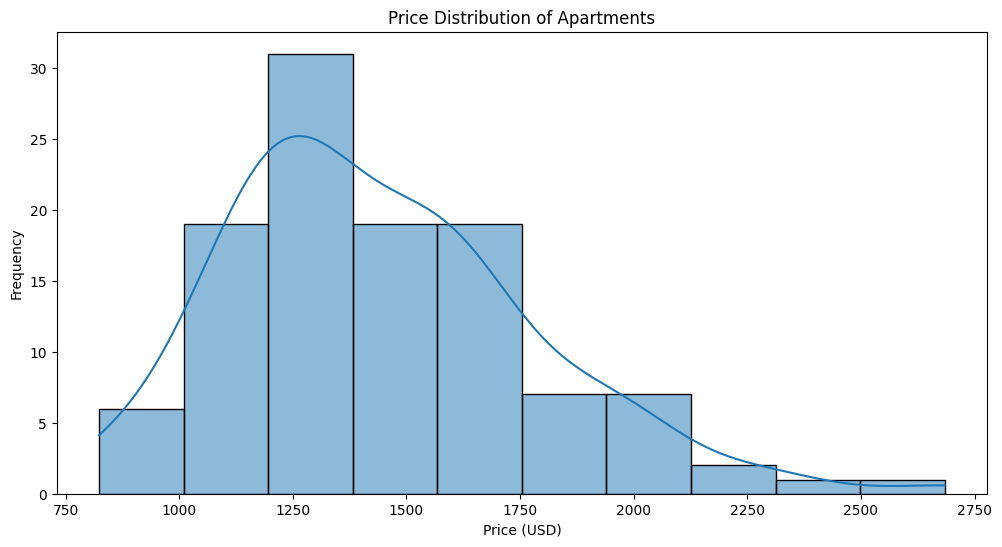

In [42]:
# create a histogram to visualize data
from matplotlib import figure
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=10, kde=True)  # Include KDE for smoother distribution
plt.title('Price Distribution of Apartments')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')


([0, 1, 2, 3],
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

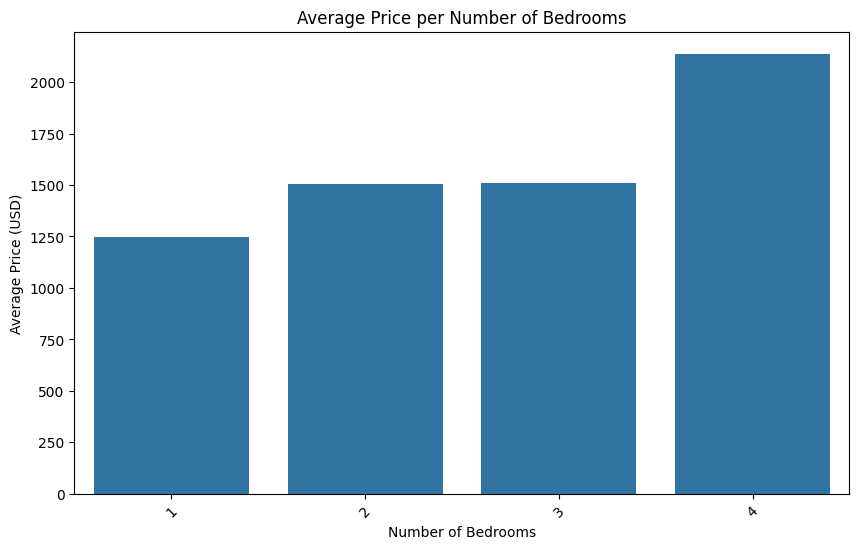

In [43]:
avg_price_per_bedroom = df.groupby('bedroom_no')['price'].mean().reset_index()
avg_price_per_bedroom.columns = ['bedroom_no', 'average_price']

plt.figure(figsize=(10, 6))
sns.barplot(x='bedroom_no', y='average_price', data=avg_price_per_bedroom)
plt.title('Average Price per Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Price (USD)')
plt.xticks(rotation=45)

### Bar plot was used to demonstate the relationship between average rental prices and number of bedrooms

Interestingly, homes with three bedrooms tend to have the same price as those with two bedrooms. Additionally, four-bedroom houses are significantly pricier than the others, indicating that larger homes command a premium in the rental market.

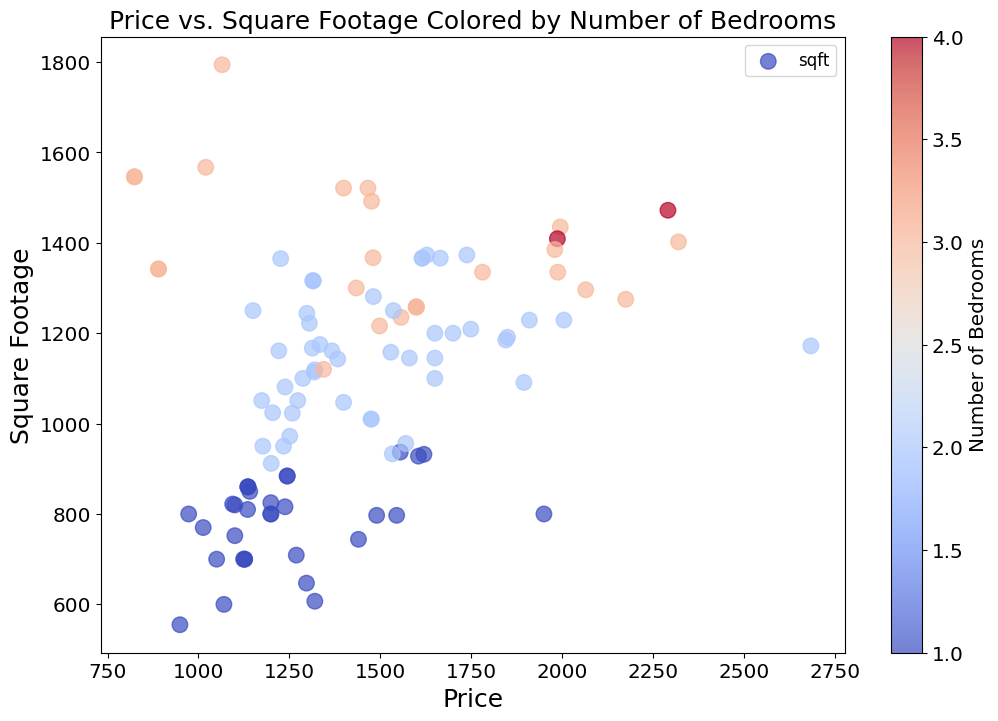

In [44]:
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (15, 5),
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
plt.rcParams.update(params)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter('price', 'sqft', c='bedroom_no', cmap='coolwarm', 
                      s=125, data=df.dropna(), alpha=0.7)

# Add colorbar
plt.colorbar(scatter, label='Number of Bedrooms')

# Customize the plot
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18)
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18)
plt.legend(fontsize=12)

### Scatter Plots was used to illustrate the relationships between price, sqft, and number of bedrooms.


Text(0, 0.5, 'Square Feet')

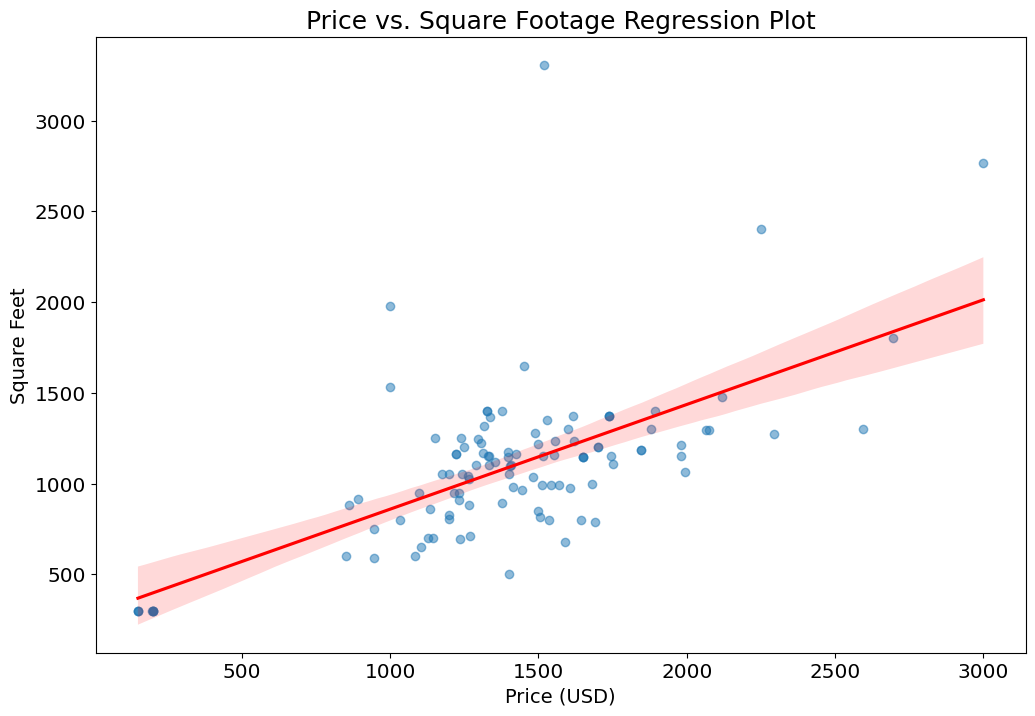

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare the figure
plt.figure(figsize=(12, 8))

# Scatter plot with regression line
sns.regplot(x='price', y='sqft', data=df.dropna(), scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})

# Title and labels
plt.title('Price vs. Square Footage Regression Plot', fontsize=18)
plt.xlabel("Price (USD)", fontsize=14)
plt.ylabel("Square Feet", fontsize=14)


### Regression Plot
The regression plot between price and square footage generally demonstrates a positive correlation, suggesting that as the square footage increases, rental prices also tend to rise. However, the plot also reveals the presence of outliers, which may indicate properties that significantly deviate from the expected price trend based on their size. These outliers warrant further investigation, as they can skew average rental prices and impact market analysis.

In [45]:
df.corr()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19760\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,bedroom_no,sqft,price
bedroom_no,1.000000,0.827308,0.379497
sqft,0.827308,1.000000,0.344218
price,0.379497,0.344218,1.000000


In [46]:
#group by neighborhood
df.groupby('neighborhood').mean()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19760\984949247.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('neighborhood').mean()


,bedroom_no,sqft,price
neighborhood,,,
Alpharetta,2.166667,1210.500000,1969.166667
Atlanta,1.750000,1140.833333,1692.080000
Austell,2.428571,1183.571429,1435.571429
Canton,2.000000,933.000000,1533.000000
Cartersville,4.000000,1409.000000,1987.000000
College Park,1.000000,689.750000,1115.750000
Conyers,2.000000,1023.000000,1258.000000
Covington,2.000000,1316.000000,1315.000000
Dacula,1.000000,700.000000,1127.000000


In [47]:
#sort price to find cheapest
df.groupby('neighborhood').mean()['price'].sort_values()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19760\1113310204.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('neighborhood').mean()['price'].sort_values()


neighborhood
Stockbridge        890.000000
College Park      1115.750000
Dacula            1127.000000
Lithonia          1132.333333
Riverdale         1135.750000
Lilburn           1165.500000
Stone Mountain    1214.111111
Roswell           1226.000000
Snellville        1236.333333
Conyers           1258.000000
Doraville         1287.000000
Douglasville      1305.000000
Newnan            1309.500000
Covington         1315.000000
Jonesboro         1325.666667
East Point        1334.000000
Woodstock         1396.500000
Austell           1435.571429
Morrow            1468.750000
Marietta          1475.000000
Decatur           1518.400000
Canton            1533.000000
Lawrenceville     1568.600000
Tucker            1570.000000
Norcross          1675.000000
Atlanta           1692.080000
Alpharetta        1969.166667
Cartersville      1987.000000
Name: price, dtype: float64

### The grouped data shows average rental characteristics by neighborhood, revealing notable insights:
- Highest Average Prices: Cartersville leads with an average price of $1,987 for rentals, indicating a premium market.
- Lowest Average Prices: Stockbridge shows a relatively lower average price of $890, suggesting a more affordable rental market.
- Bedrooms and Square Footage: Neighborhoods like Cartersville have high average bedroom counts and square footage, while others like Dacula and Riverdale have lower averages.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19760\1693958371.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='neighborhood', y='price', data=df, palette='coolwarm')


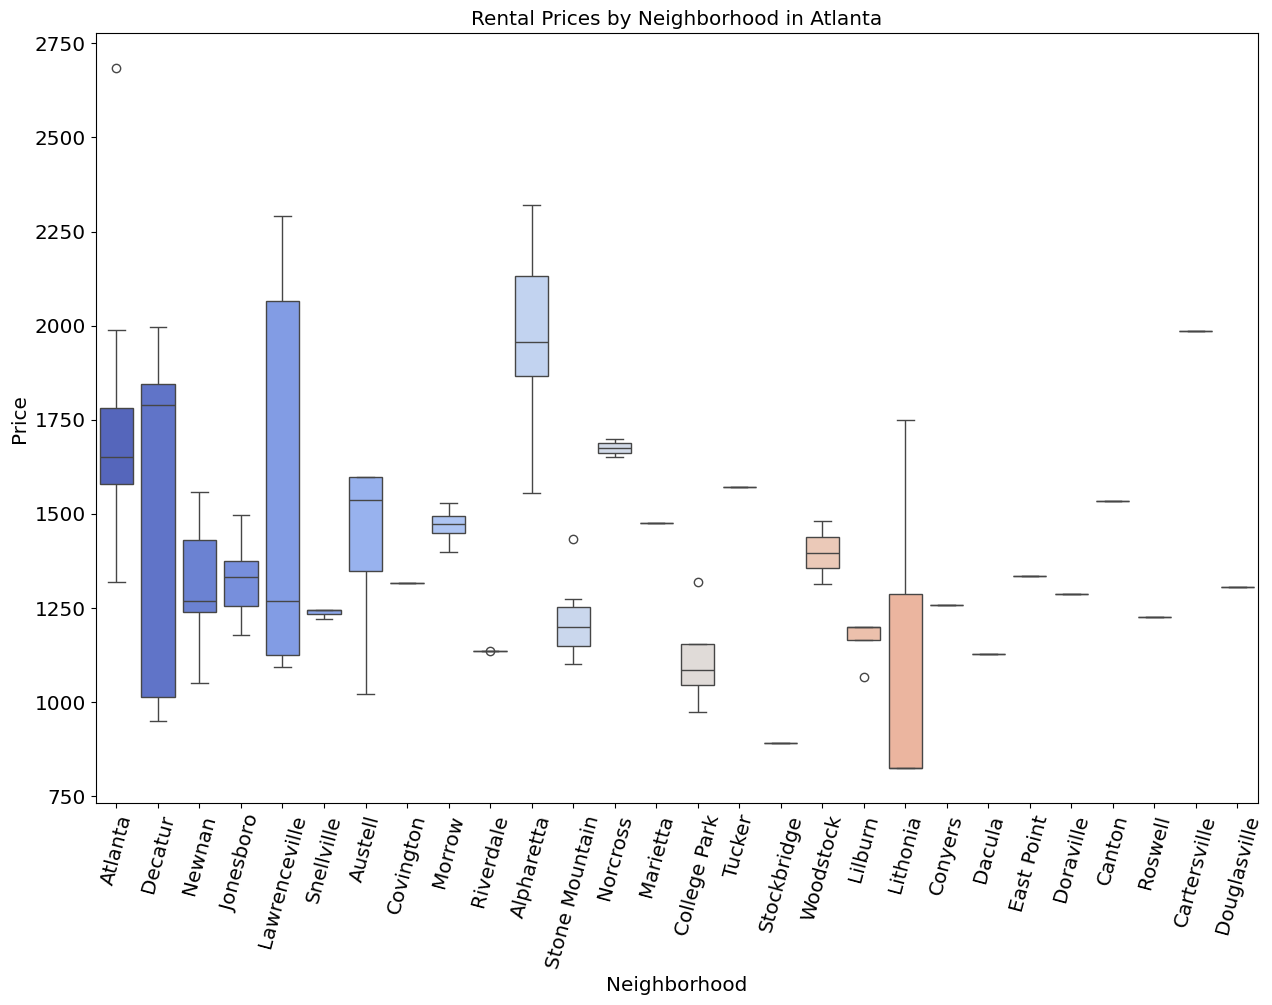

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Set plot parameters
plt.figure(figsize=(15,10))
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (15, 5),
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
matplotlib.rcParams.update(params)

# Plot
sns.boxplot(x='neighborhood', y='price', data=df, palette='coolwarm')
plt.xlabel("Neighborhood")
plt.ylabel("Price")
plt.title("Rental Prices by Neighborhood in Atlanta")
plt.xticks(rotation=75)
plt.show()


### Boxplot

The boxplot reveals that both Decatur and Lawrenceville have a wide spread in rental prices, indicating a considerable range between the lower and upper quartiles. This variability suggests that while there are affordable options, there are also significantly higher-priced properties within the same neighborhoods. Additionally, the boxplot analysis shows that Atlanta, Stone Mountain, College Park and Lilburn exhibit some outliers in rental prices. These outliers suggest that there are properties in these neighborhoods priced significantly higher or lower than the typical range. This can indicate unique features, amenities, or market fluctuations in these areas.




## 4. Regression Analysis

In [52]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

regression_data = df.dropna()
X = regression_data[['sqft', 'bedroom_no']]  # independent variables
X = sm.add_constant(X)  # add constant for intercept
y = regression_data['price']  # dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# View the summary of the regression
print(model.summary())

# Predict on the test set
y_pred = model.predict(X_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     6.551
Date:                Wed, 30 Oct 2024   Prob (F-statistic):            0.00229
Time:                        21:41:15   Log-Likelihood:                -615.37
No. Observations:                  85   AIC:                             1237.
Df Residuals:                      82   BIC:                             1244.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1155.9421    186.425      6.201      0.0

### Model Fit (R-squared and Adjusted R-squared):

R-squared: The model explains 13.8% of the variation in rental prices, indicating that sqft and bedroom_no have a limited ability to explain price differences on their own.
Adjusted R-squared: Adjusted for the number of predictors, this value is slightly lower at 11.7%, confirming that only a small proportion of the variance in price is captured by these predictors.
Statistical Significance (F-statistic):

F-statistic: With a value of 6.551 and a p-value of 0.00229, the overall model is statistically significant at a conventional 5% level. This suggests that, collectively, sqft and bedroom_no provide some explanatory power for predicting price.
Coefficients and Interpretations:

Intercept (const): The intercept of 1155.94 suggests the estimated base price when both sqft and bedroom_no are zero. Although this does not have a practical real-world interpretation here (as square footage and bedrooms would never be zero in a typical rental property), it represents the base level from which changes in the predictors affect price.
sqft (Square Footage): The coefficient is -0.0357, with a very high p-value (0.902). This result implies that sqft has an extremely small, statistically insignificant effect on price, suggesting that square footage does not contribute to explaining rental prices in this model.
bedroom_no (Number of Bedrooms): The coefficient of 179.26 suggests that, on average, each additional bedroom is associated with an increase in rental price by approximately $179.26. However, the p-value (0.061) is marginally above the conventional 5% significance level, so we can only consider this result borderline significant.
Residual Diagnostics:

Durbin-Watson: The value of 1.949 is close to 2, suggesting no major issue with autocorrelation in residuals.
Condition Number: The condition number is quite high (5.92e+03), which may indicate multicollinearity, meaning that sqft and bedroom_no might be correlated with each other. This can affect the stability of the coefficient estimates.
Normality of Residuals:

Omnibus and Jarque-Bera Tests: The p-values here suggest slight deviation from normality, with a p-value just below 0.05 for Jarque-Bera. While minor, this may affect the reliability of confidence intervals and p-values.